In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [2]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Time Series/Avg_Travel_Time_50_Routes.csv')

In [4]:
data.head()

,week,travel_time
0,12/27/15,24.738444
1,1/3/16,27.119342
2,1/10/16,29.542540
3,1/17/16,29.085661
4,1/24/16,31.035735


In [5]:
features = pd.read_csv('/content/drive/MyDrive/Time Series/features.csv')

In [6]:
features.head()

,week,avg_temp,avg_humidity,holiday
0,12/27/15,55.062500,26.263333,False
1,1/3/16,54.415094,73.246792,True
2,1/10/16,55.858953,73.944084,True
3,1/17/16,58.247414,85.364828,False
4,1/24/16,59.434831,56.483034,True


In [7]:
# Convert "holiday" variable to numerical form
features['holiday'] = features['holiday'].astype(int)

In [8]:
# Assuming you have your data in a DataFrame called "data"
input_vars = features[['avg_temp', 'avg_humidity', 'holiday']].values
output_var = data['travel_time'].values

In [9]:
# Set seed for reproducibility
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

# Normalize input variables
input_mean, input_std = np.mean(input_vars, axis=0), np.std(input_vars, axis=0)
input_vars = (input_vars - input_mean) / input_std

# Normalize output variable
output_mean, output_std = np.mean(output_var, axis=0), np.std(output_var, axis=0)
output_var = (output_var - output_mean) / output_std

sequence_length = 12  

# Generate input-output sequences
X = []
y = []
for i in range(sequence_length, len(output_var)):
    X.append(np.concatenate((input_vars[i-sequence_length:i], output_var[i-sequence_length:i, np.newaxis]), axis=1))
    y.append(output_var[i])

X = np.array(X)
y = np.array(y)

# Define the number of splits for cross-validation
n_splits = 5 

tscv = TimeSeriesSplit(n_splits=n_splits)

# Arrays to store predictions from each fold
all_y_pred = []
rmse_scores = []

# Perform walk-forward cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = keras.Sequential()
    model.add(layers.LSTM(units=64, activation='relu', input_shape=(sequence_length, input_vars.shape[1]+1)))
    model.add(layers.Dense(units=1))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=100, batch_size=32)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)
    print('Test RMSE:', rmse)

    # Rescale the predicted values
    y_pred = (y_pred * output_std) + output_mean
    
    all_y_pred.append(y_pred)

Epoch 1/100
2/2 [==============================] - 5s 78ms/step - loss: 0.3823
Epoch 2/100
2/2 [==============================] - 0s 22ms/step - loss: 0.3586
Epoch 3/100
2/2 [==============================] - 0s 29ms/step - loss: 0.3387
Epoch 4/100
2/2 [==============================] - 0s 30ms/step - loss: 0.3231
Epoch 5/100
2/2 [==============================] - 0s 19ms/step - loss: 0.3078
Epoch 6/100
2/2 [==============================] - 0s 16ms/step - loss: 0.2937
Epoch 7/100
2/2 [==============================] - 0s 15ms/step - loss: 0.2850
Epoch 8/100
2/2 [==============================] - 0s 17ms/step - loss: 0.2748
Epoch 9/100
2/2 [==============================] - 0s 20ms/step - loss: 0.2713
Epoch 10/100
2/2 [==============================] - 0s 19ms/step - loss: 0.2670
Epoch 11/100
2/2 [==============================] - 0s 17ms/step - loss: 0.2658
Epoch 12/100
2/2 [==============================] - 0s 39ms/step - loss: 0.2688
Epoch 13/100
2/2 [==============================]

2/2 [==============================] - 0s 10ms/step
Test RMSE: 1.270038395023313


In [10]:
rmse_scores

[1.3962829938670525,
 1.2082081103678783,
 0.7918232341604777,
 0.7540887215891183,
 1.270038395023313]

In [11]:
# Calculate average predicted values across all folds
avg_y_pred = np.mean(all_y_pred, axis=0)

# Rescale the actual values
output_var = (output_var * output_std) + output_mean

# Calculate and print the average RMSE across all cross-validation folds
print('Average RMSE:', np.mean(rmse_scores))

Average RMSE: 1.084088291001568


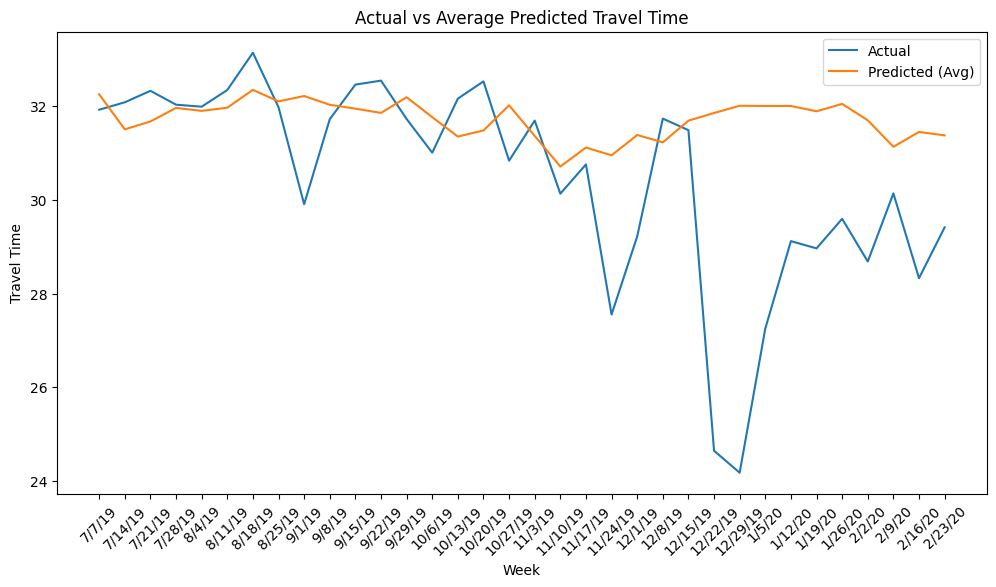

In [12]:
# Plot actual vs average predicted values
last_34_weeks = data['week'].iloc[-34:]  # Assuming 'week' column contains week labels
plt.figure(figsize=(12, 6))
plt.plot(last_34_weeks, output_var[-34:], label='Actual')
plt.plot(last_34_weeks, avg_y_pred[-34:], label='Predicted (Avg)')
plt.xlabel('Week')
plt.ylabel('Travel Time')
plt.title('Actual vs Average Predicted Travel Time')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [13]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
xgboost = pd.read_csv('/content/drive/MyDrive/Time Series/xgboost_output.csv')

# Keep only the "predictions" column
predictions = xgboost['predictions']

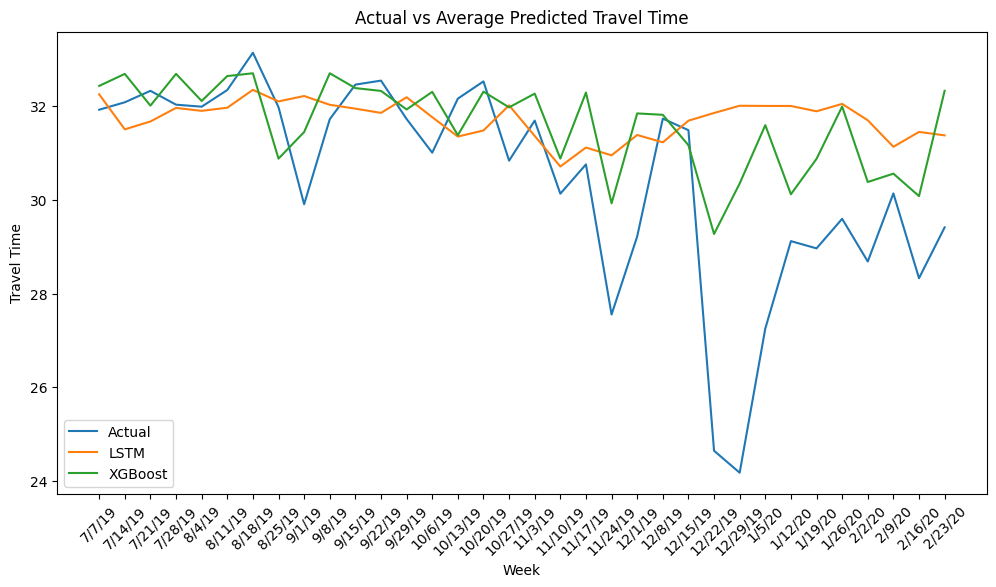

In [14]:
# Plot actual vs average predicted values
last_34_weeks = data['week'].iloc[-34:]  # Assuming 'week' column contains week labels
plt.figure(figsize=(12, 6))
plt.plot(last_34_weeks, output_var[-34:], label='Actual')
plt.plot(last_34_weeks, avg_y_pred[-34:], label='LSTM')
plt.plot(last_34_weeks, predictions[-34:], label='XGBoost')

plt.xlabel('Week')
plt.ylabel('Travel Time')
plt.title('Actual vs Average Predicted Travel Time')
plt.legend()
plt.xticks(rotation=45)
plt.show()